In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score,roc_curve,auc
import shap
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns

Loading the dataset

---



In [ ]:
df = pd.read_csv("data.csv")
df.head()

,Unnamed: 0,subject_id,hospital_expire_flag,max_age,los_icu,first_hosp_stay,suspected_infection,sofa_score,sepsis3,avg_urineoutput,...,race_Hispanic or Latin,race_Others race,race_White,antibiotic_Vancomycin,antibiotic_Vancomycin Antibiotic Lock,antibiotic_Vancomycin Enema,antibiotic_Vancomycin Intrathecal,antibiotic_Vancomycin Oral Liquid,gender_F,gender_M
0,0,19986715,0,24,10.58,True,1,2,True,136.657143,...,0,0,0,1,0,0,0,0,1,0
1,1,19973083,0,58,2.33,True,1,8,True,34.263158,...,0,0,0,1,0,0,0,0,1,0
2,2,19907774,1,65,1.83,True,1,2,True,105.476191,...,0,0,0,1,0,0,0,0,1,0
3,3,19894745,1,76,1.08,True,1,4,True,34.000000,...,0,0,0,1,0,0,0,0,1,0
4,4,19884808,1,64,20.46,True,1,5,True,107.229508,...,0,0,0,1,0,0,0,0,1,0


Dataset Description

---


In [ ]:
from IPython.display import Markdown, display

# Read and display as Markdown
file_path = "/content/dataset_description.txt"

with open(file_path, "r") as file:
    content = file.read()

display(Markdown(content))


### Dataset Description

#### 1. Patient & Stay Information:
- **subject_id** – A unique identifier for each patient.
- **first_hosp_stay** – Indicates if this is the patient’s first hospital stay (likely a binary flag: `1` = Yes).
- **los_icu** – Length of Stay (LOS) in the ICU, measured in days.

#### 2. Outcome & Severity Indicators:
- **hospital_expire_flag** – Whether the patient expired in the hospital (`0` = No, `1` = Yes).
- **sepsis3** – Indicator for sepsis diagnosis based on Sepsis-3 criteria.
- **sofa_score** – Sequential Organ Failure Assessment (SOFA) score, used to measure organ dysfunction.
- **coma** – Whether the patient is in a coma (`0` or `1`).

#### 3. Infection & Medication:
- **suspected_infection** – Indicates if an infection is suspected (`1` = Yes).
- **antibiotic_Vancomycin** – Whether the patient was administered Vancomycin, a broad-spectrum antibiotic.
- **antibiotic_Vancomycin Antibiotic Lock** – Vancomycin given as a catheter lock solution.
- **antibiotic_Vancomycin Enema** – Vancomycin administered rectally.
- **antibiotic_Vancomycin Intrathecal** – Vancomycin administered into the spinal canal.
- **antibiotic_Vancomycin Oral Liquid** – Vancomycin administered as an oral liquid.

#### 4. Vital Signs & Lab Measurements:
- **Heart Rate:**
  - **heart_rate_min** – Minimum recorded heart rate.
  - **heart_rate_max** – Maximum recorded heart rate.
  - **heart_rate_mean** – Average heart rate.

- **Blood Pressure:**
  - **sbp_min**, **sbp_max**, **sbp_mean** – Systolic Blood Pressure (SBP) values.
  - **dbp_min**, **dbp_max**, **dbp_mean** – Diastolic Blood Pressure (DBP) values.

- **Respiratory Rate:**
  - **resp_rate_min**, **resp_rate_max**, **resp_rate_mean** – Minimum, maximum, and average respiratory rate.

- **Oxygen Saturation (SpO₂):**
  - **spo2_min**, **spo2_max**, **spo2_mean** – Minimum, maximum, and average oxygen saturation.

- **Glucose Levels:**
  - **glucose_min**, **glucose_max**, **glucose_average** – Blood glucose levels.

- **Sodium Levels:**
  - **sodium_max**, **sodium_min**, **sodium_average** – Sodium concentration in the blood.

- **albumin** – Serum albumin levels, an indicator of nutrition and liver function.
- **avg_urineoutput** – Average urine output, used to assess kidney function.

#### 5. Comorbidities (Pre-Existing Conditions):
- **diabetes_without_cc** – Patient has diabetes but without chronic complications (`0` or `1`).
- **diabetes_with_cc** – Patient has diabetes with chronic complications (`0` or `1`).
- **severe_liver_disease** – Indicates severe liver disease presence (`0` or `1`).
- **aids** – Whether the patient has AIDS (`0` or `1`).
- **renal_disease** – Presence of kidney disease (`0` or `1`).

#### 6. Demographics:
- **max_age** – The patient’s age at admission.

- **Race/Ethnicity Indicators:** (`0` or `1`)
  - **race_Black or African American**
  - **race_Hispanic or Latin**
  - **race_Others race**
  - **race_White**

- **Gender Indicators:** (`0` or `1`)
  - **gender_F** – Female patient.
  - **gender_M** – Male patient.


In [ ]:
df = df.drop(df.columns[0], axis=1)
df.head()

,subject_id,hospital_expire_flag,max_age,los_icu,first_hosp_stay,suspected_infection,sofa_score,sepsis3,avg_urineoutput,glucose_min,...,race_Hispanic or Latin,race_Others race,race_White,antibiotic_Vancomycin,antibiotic_Vancomycin Antibiotic Lock,antibiotic_Vancomycin Enema,antibiotic_Vancomycin Intrathecal,antibiotic_Vancomycin Oral Liquid,gender_F,gender_M
0,19986715,0,24,10.58,True,1,2,True,136.657143,82,...,0,0,0,1,0,0,0,0,1,0
1,19973083,0,58,2.33,True,1,8,True,34.263158,94,...,0,0,0,1,0,0,0,0,1,0
2,19907774,1,65,1.83,True,1,2,True,105.476191,65,...,0,0,0,1,0,0,0,0,1,0
3,19894745,1,76,1.08,True,1,4,True,34.000000,267,...,0,0,0,1,0,0,0,0,1,0
4,19884808,1,64,20.46,True,1,5,True,107.229508,146,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
print("Dataset Shape:", df.shape)
print("Missing Values:", df.isnull().sum().sum())
print("Duplicate Rows:", df.duplicated().sum())
print("Unique Values:")
df.nunique()

Dataset Shape: (5208, 48)
Missing Values: 0
Duplicate Rows: 0
Unique Values:


,0
subject_id,5208
hospital_expire_flag,2
max_age,82
los_icu,684
first_hosp_stay,1
suspected_infection,1
sofa_score,18
sepsis3,1
avg_urineoutput,4396
glucose_min,252


In [ ]:
print("Summary Statistics:\n")
df.describe()

Summary Statistics:



,subject_id,hospital_expire_flag,max_age,los_icu,suspected_infection,sofa_score,avg_urineoutput,glucose_min,glucose_max,glucose_average,...,race_Hispanic or Latin,race_Others race,race_White,antibiotic_Vancomycin,antibiotic_Vancomycin Antibiotic Lock,antibiotic_Vancomycin Enema,antibiotic_Vancomycin Intrathecal,antibiotic_Vancomycin Oral Liquid,gender_F,gender_M
count,5.208000e+03,5208.000000,5208.00000,5208.000000,5208.0,5208.000000,5208.000000,5208.000000,5208.000000,5208.000000,...,5208.000000,5208.000000,5208.000000,5208.000000,5208.000000,5208.000000,5208.0,5208.000000,5208.000000,5208.000000
mean,1.501884e+07,0.230991,64.77573,6.668679,1.0,4.407642,173.875040,100.759793,227.380760,150.629823,...,0.053955,0.178379,0.636137,0.852727,0.001536,0.008449,0.0,0.059524,0.416091,0.583909
std,2.886479e+06,0.421507,15.83041,8.633552,0.0,2.446178,118.797223,36.762319,173.129955,59.613033,...,0.225951,0.382869,0.481156,0.354412,0.039167,0.091536,0.0,0.236625,0.492956,0.492956
min,1.000201e+07,0.000000,19.00000,1.040000,1.0,2.000000,-100.000000,3.000000,35.000000,34.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,1.254311e+07,0.000000,55.00000,1.960000,1.0,2.000000,97.054825,79.000000,140.000000,113.833333,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,1.498578e+07,0.000000,66.00000,3.480000,1.0,4.000000,153.000000,96.000000,182.000000,134.500000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000
75%,1.755050e+07,0.000000,76.00000,7.710000,1.0,6.000000,219.428788,116.000000,256.000000,170.500000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000
max,1.999789e+07,1.000000,101.00000,101.750000,1.0,20.000000,1537.500000,594.000000,5840.000000,891.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


<ipython-input-7-b16142ba133d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hospital_expire_flag', data=df, palette='coolwarm')


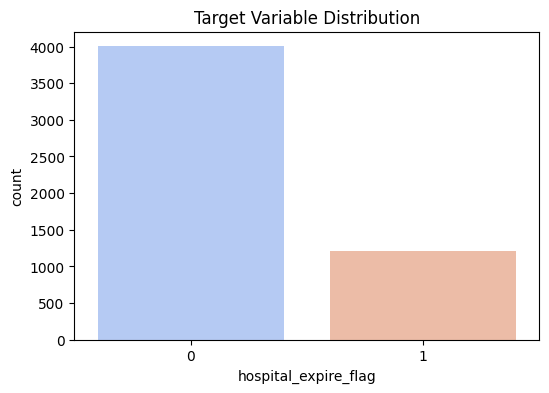

In [ ]:
#Distribution of Target Variable
plt.figure(figsize=(6,4))
sns.countplot(x='hospital_expire_flag', data=df, palette='coolwarm')
plt.title("Target Variable Distribution")
plt.show()

             Features  Correlation
                 coma     0.149961
           sofa_score     0.124907
       resp_rate_mean     0.123988
        resp_rate_max     0.111966
       heart_rate_max     0.102559
 severe_liver_disease     0.092304
antibiotic_Vancomycin     0.090209
      heart_rate_mean     0.073573
              los_icu     0.072592
              max_age     0.058536
          glucose_min    -0.051236
            spo2_mean    -0.074220
           sodium_min    -0.074336
             dbp_mean    -0.105440
      avg_urineoutput    -0.113512
              albumin    -0.125716
             spo2_min    -0.127147
             sbp_mean    -0.132240
              dbp_min    -0.161527
              sbp_min    -0.177369


<ipython-input-8-8cc51ab0af37>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_bottom_features.values, y=top_bottom_features.index, palette='coolwarm')


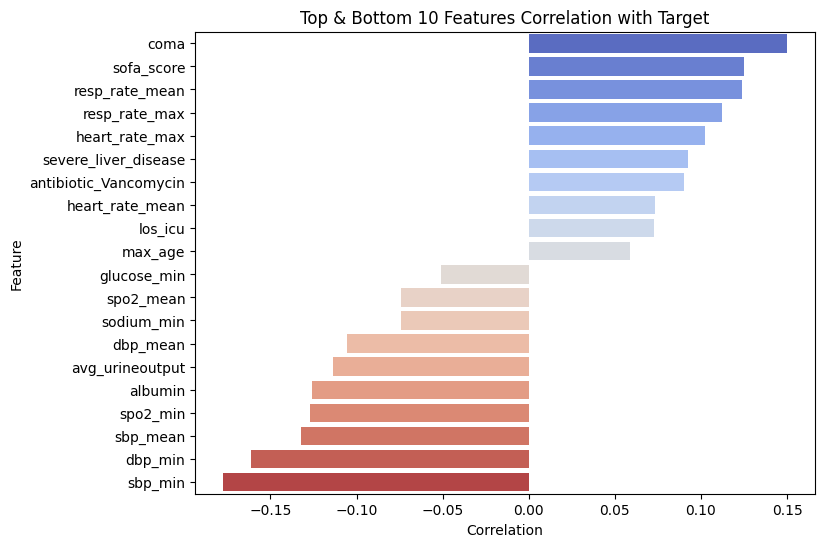

In [ ]:
# Compute correlation with target
corr_target = df.corr()['hospital_expire_flag'].drop('hospital_expire_flag').sort_values(ascending=False).dropna()

# Select top 10 and bottom 10 features
top_bottom_features = pd.concat([corr_target.head(10), corr_target.tail(10)])

# Convert correlation values into a DataFrame for better display
df_corr = top_bottom_features.reset_index()
df_corr.columns = ['Features', 'Correlation']


print(df_corr.to_string(index=False))

# Plot
plt.figure(figsize=(8,6))
sns.barplot(x=top_bottom_features.values, y=top_bottom_features.index, palette='coolwarm')
plt.title("Top & Bottom 10 Features Correlation with Target")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.show()

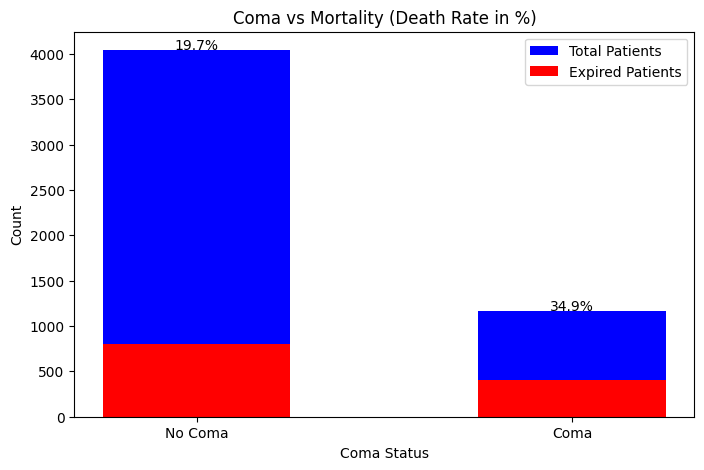

In [ ]:
# Plot Coma Cases vs Mortality
plt.figure(figsize=(8, 5))

total_coma_counts = df['coma'].value_counts().sort_index()
death_coma_counts = df[df['hospital_expire_flag'] == 1]['coma'].value_counts().sort_index()
death_coma_rates = (death_coma_counts / total_coma_counts * 100).fillna(0)

bar_width = 0.5
plt.bar(total_coma_counts.index, total_coma_counts.values, color='blue', width=bar_width, label='Total Patients')
plt.bar(death_coma_counts.index, death_coma_counts.values, color='red', width=bar_width, label='Expired Patients')

for i in total_coma_counts.index:
    plt.text(i, total_coma_counts[i] + 5, f"{death_coma_rates[i]:.1f}%", ha='center', fontsize=10, color='black')

plt.xticks([0, 1], ['No Coma', 'Coma'])
plt.xlabel("Coma Status")
plt.ylabel("Count")
plt.title("Coma vs Mortality (Death Rate in %)")
plt.legend()
plt.show()



```
0–6: Low risk of mortality.
7–9: Moderate risk.
10–12: High risk.
≥13: Very high risk, often associated with multi-organ failure.
```



In [ ]:
df["sofa_score"].value_counts()

,count
sofa_score,
2,1312
3,994
4,945
5,606
6,462
7,304
8,193
9,143
10,114


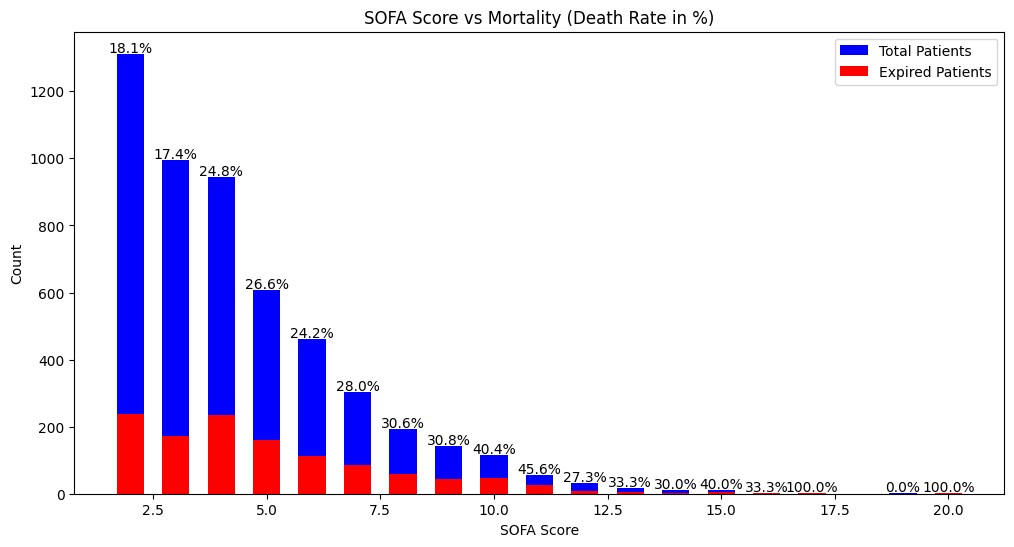

In [ ]:
# Plot SOFA Score vs Mortality
plt.figure(figsize=(12, 6))

total_counts = df['sofa_score'].value_counts().sort_index()
death_counts = df[df['hospital_expire_flag'] == 1]['sofa_score'].value_counts().sort_index()
death_rates = (death_counts / total_counts * 100).fillna(0)

bar_width = 0.6
plt.bar(total_counts.index, total_counts.values, color='blue', width=bar_width, label='Total Patients')
plt.bar(death_counts.index, death_counts.values, color='red', width=bar_width, label='Expired Patients')

for i in total_counts.index:
    plt.text(i, total_counts[i] + 5, f"{death_rates[i]:.1f}%", ha='center', fontsize=10, color='black')

plt.xlabel("SOFA Score")
plt.ylabel("Count")
plt.title("SOFA Score vs Mortality (Death Rate in %)")
plt.legend()
plt.show()

<ipython-input-12-4822dc7f3de8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['sofa_score'], y=df['los_icu'], palette='viridis')


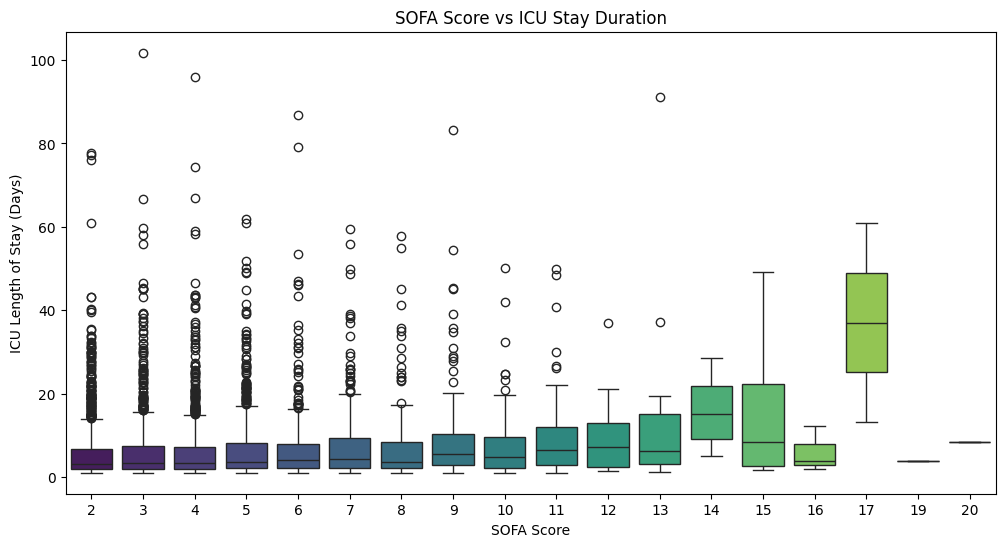

In [ ]:
# Boxplot of SOFA Score vs ICU Length of Stay
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['sofa_score'], y=df['los_icu'], palette='viridis')
plt.xlabel("SOFA Score")
plt.ylabel("ICU Length of Stay (Days)")
plt.title("SOFA Score vs ICU Stay Duration")
plt.show()

<ipython-input-13-383411a9cc83>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dbp_death_rate = df.groupby(dbp_bins)['hospital_expire_flag'].mean() * 100


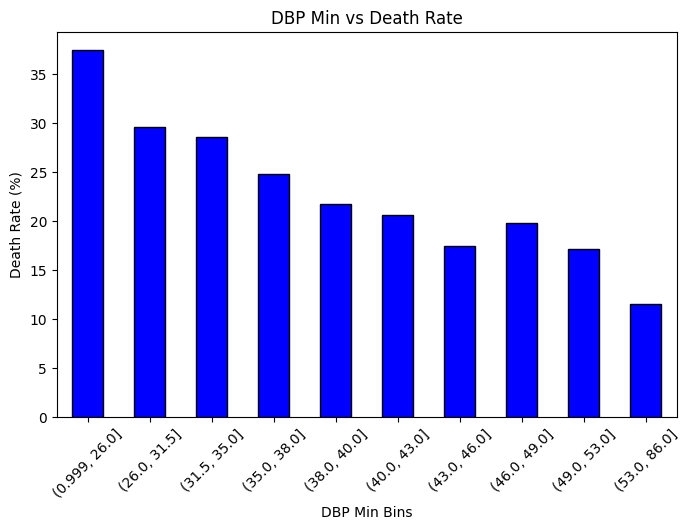

<ipython-input-13-383411a9cc83>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sbp_death_rate = df.groupby(sbp_bins)['hospital_expire_flag'].mean() * 100


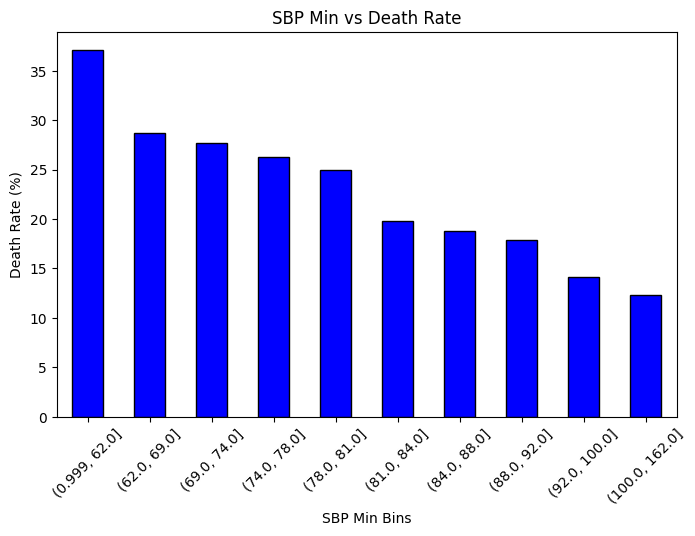

In [ ]:

# Plot DBP Min vs Death Rate
plt.figure(figsize=(8, 5))

dbp_bins = pd.qcut(df['dbp_min'], q=10, duplicates='drop')
dbp_death_rate = df.groupby(dbp_bins)['hospital_expire_flag'].mean() * 100

dbp_death_rate.plot(kind='bar', color='blue', edgecolor='black')
plt.xlabel("DBP Min Bins")
plt.ylabel("Death Rate (%)")
plt.title("DBP Min vs Death Rate")
plt.xticks(rotation=45)
plt.show()

# Plot SBP Min vs Death Rate
plt.figure(figsize=(8, 5))

sbp_bins = pd.qcut(df['sbp_min'], q=10, duplicates='drop')
sbp_death_rate = df.groupby(sbp_bins)['hospital_expire_flag'].mean() * 100

sbp_death_rate.plot(kind='bar', color='blue', edgecolor='black')
plt.xlabel("SBP Min Bins")
plt.ylabel("Death Rate (%)")
plt.title("SBP Min vs Death Rate")
plt.xticks(rotation=45)
plt.show()

In [ ]:
unique_1_2_cols = [col for col in df.columns if df[col].nunique() in [1, 2]]

df_unique_1_2 = pd.DataFrame({
    'Column Name': unique_1_2_cols,
    'Unique Values': [", ".join(map(str, df[col].unique())) for col in unique_1_2_cols],
    'Counts': [df[col].value_counts().to_dict() for col in unique_1_2_cols]
})

import pandas as pd
pd.set_option("display.max_colwidth", None)
df_unique_1_2


,Column Name,Unique Values,Counts
0,hospital_expire_flag,"0, 1","{0: 4005, 1: 1203}"
1,first_hosp_stay,True,{True: 5208}
2,suspected_infection,1,{1: 5208}
3,sepsis3,True,{True: 5208}
4,diabetes_without_cc,"0, 1","{0: 3643, 1: 1565}"
5,diabetes_with_cc,"0, 1","{0: 4431, 1: 777}"
6,severe_liver_disease,"0, 1","{0: 4452, 1: 756}"
7,aids,"0, 1","{0: 5119, 1: 89}"
8,renal_disease,"0, 1","{0: 3558, 1: 1650}"
9,coma,"0, 1","{0: 4044, 1: 1164}"


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score,roc_curve,auc
import shap
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [ ]:
df = pd.read_csv("data.csv")
df = df.drop(df.columns[0], axis=1)

In [ ]:
target = 'hospital_expire_flag'
features = df.columns[df.columns != target]

In [ ]:
X = df[features]
y = df[target]

Mean Imputation

---



In [ ]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
X = pd.DataFrame(knn_imputer.fit_transform(X), columns=X.columns)

Resampling using SMOTE

---



In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

<ipython-input-9-107a90913275>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='coolwarm')


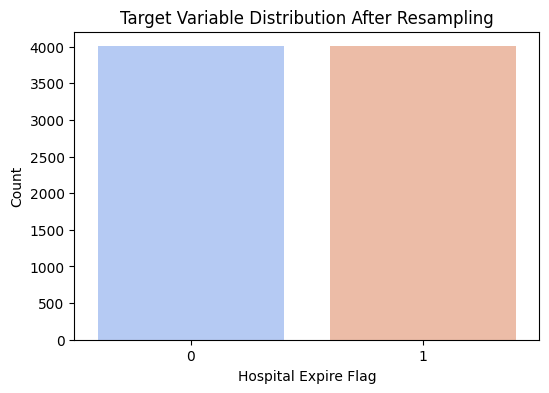

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled, palette='coolwarm')
plt.title("Target Variable Distribution After Resampling")
plt.xlabel("Hospital Expire Flag")
plt.ylabel("Count")
plt.show()

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
param_grid = {
    "RandomForest": {"n_estimators": [100, 200], "max_depth": [10, 20]},
    "GradientBoosting": {"n_estimators": [100, 200]},
    "XGBoost": {"n_estimators": [100, 200]},
    "LightGBM": {"n_estimators": [100, 200]},
    "MLP": {"hidden_layer_sizes": [(100,), (200,)], "max_iter": [500, 1000]},
    "SVM": {"C": [0.1, 1, 10]},
    "DecisionTree": {"max_depth": [5, 10, 20]}
}

Using GridSearchCV

---



Tuning RandomForest with GridSearchCV...
RandomForest Performance:
              precision    recall  f1-score   support

           0       0.83      0.93      0.87       801
           1       0.92      0.81      0.86       801

    accuracy                           0.87      1602
   macro avg       0.87      0.87      0.87      1602
weighted avg       0.87      0.87      0.87      1602

Best Parameters: {'max_depth': 20, 'n_estimators': 200}
Accuracy: 0.8658
ROC-AUC Score: 0.9374
Precision: 0.9150
Recall: 0.8065
F1 Score: 0.8573
Confusion Matrix:


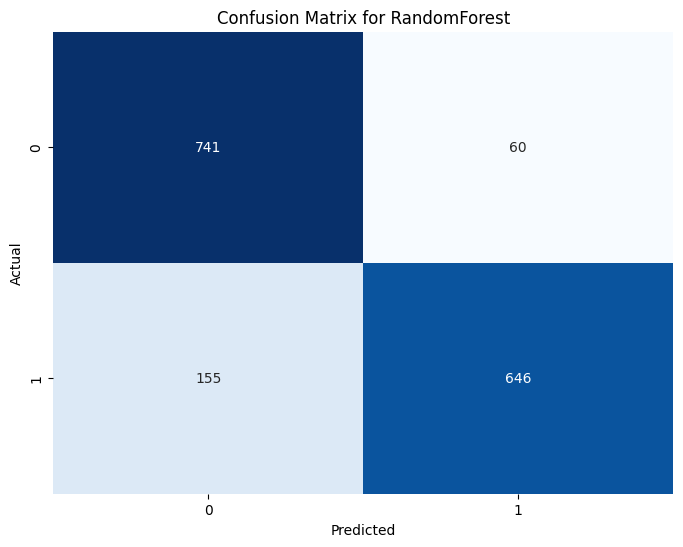

Tuning GradientBoosting with GridSearchCV...
GradientBoosting Performance:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       801
           1       0.91      0.76      0.83       801

    accuracy                           0.84      1602
   macro avg       0.85      0.84      0.84      1602
weighted avg       0.85      0.84      0.84      1602

Best Parameters: {'n_estimators': 100}
Accuracy: 0.8414
ROC-AUC Score: 0.9115
Precision: 0.9076
Recall: 0.7603
F1 Score: 0.8274
Confusion Matrix:


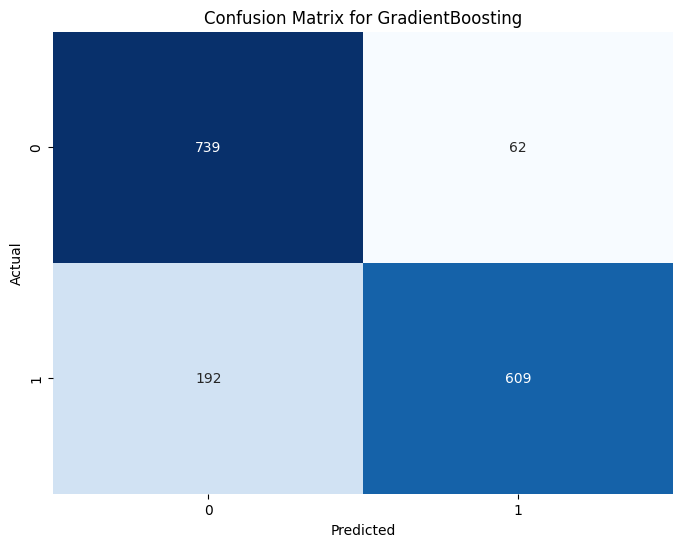

Tuning XGBoost with GridSearchCV...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:49:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Performance:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       801
           1       0.88      0.80      0.84       801

    accuracy                           0.85      1602
   macro avg       0.85      0.85      0.84      1602
weighted avg       0.85      0.85      0.84      1602

Best Parameters: {'n_estimators': 200}
Accuracy: 0.8452
ROC-AUC Score: 0.9170
Precision: 0.8835
Recall: 0.7953
F1 Score: 0.8371
Confusion Matrix:


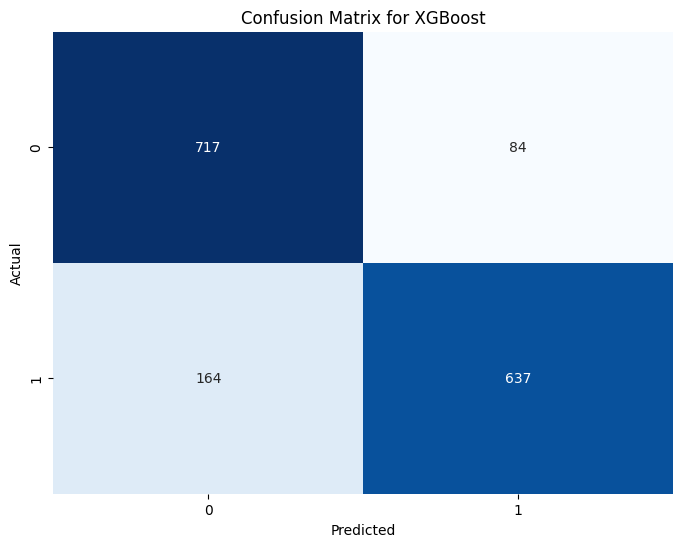

Tuning LightGBM with GridSearchCV...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3204, number of negative: 3204
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9485
[LightGBM] [Info] Number of data points in the train set: 6408, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Performance:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       801
           1       0.91      0.77      0.83       801

    accuracy                           0.85      1602
   macro avg       0.85      0.85      0.85      1602
weighted avg       0.85      0.85      0.85      1602

Best Parameters: {'n_estimators': 100}
Accuracy: 0.8464
ROC-AUC Score: 0.9159
Precision: 0.9051
Recall: 0.7740
F1 Score: 0.8345
Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


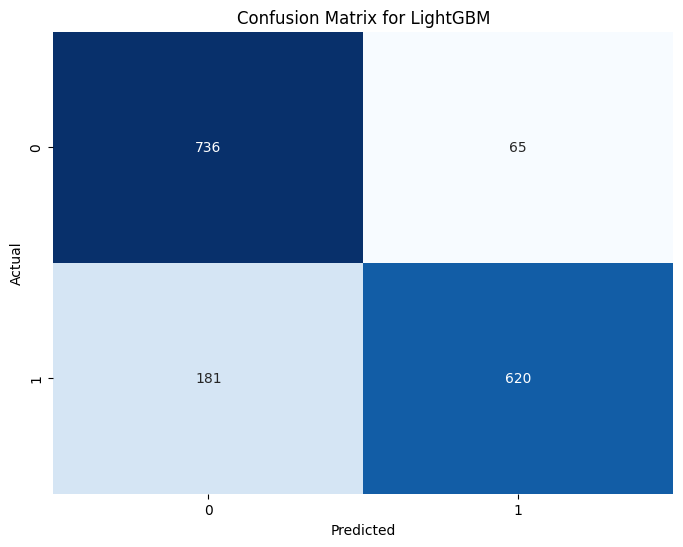

Tuning MLP with GridSearchCV...
MLP Performance:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       801
           1       0.84      0.88      0.86       801

    accuracy                           0.86      1602
   macro avg       0.86      0.86      0.86      1602
weighted avg       0.86      0.86      0.86      1602

Best Parameters: {'hidden_layer_sizes': (200,), 'max_iter': 500}
Accuracy: 0.8558
ROC-AUC Score: 0.9300
Precision: 0.8377
Recall: 0.8826
F1 Score: 0.8596
Confusion Matrix:


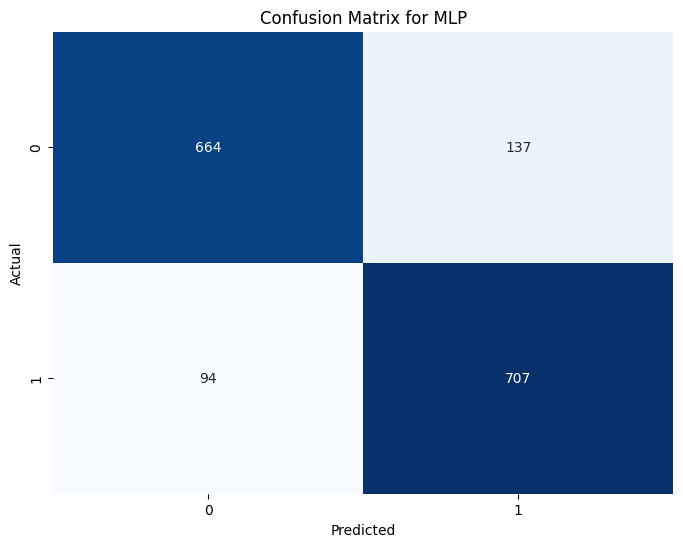

Tuning SVM with GridSearchCV...
SVM Performance:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       801
           1       0.83      0.89      0.86       801

    accuracy                           0.85      1602
   macro avg       0.85      0.85      0.85      1602
weighted avg       0.85      0.85      0.85      1602

Best Parameters: {'C': 10}
Accuracy: 0.8508
ROC-AUC Score: 0.9354
Precision: 0.8283
Recall: 0.8851
F1 Score: 0.8558
Confusion Matrix:


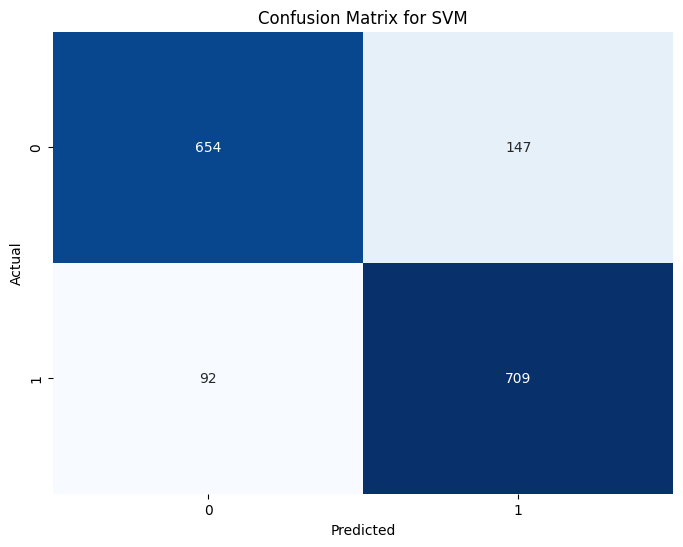

Tuning DecisionTree with GridSearchCV...
DecisionTree Performance:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       801
           1       0.73      0.74      0.73       801

    accuracy                           0.73      1602
   macro avg       0.73      0.73      0.73      1602
weighted avg       0.73      0.73      0.73      1602

Best Parameters: {'max_depth': 5}
Accuracy: 0.7316
ROC-AUC Score: 0.8226
Precision: 0.7265
Recall: 0.7428
F1 Score: 0.7346
Confusion Matrix:


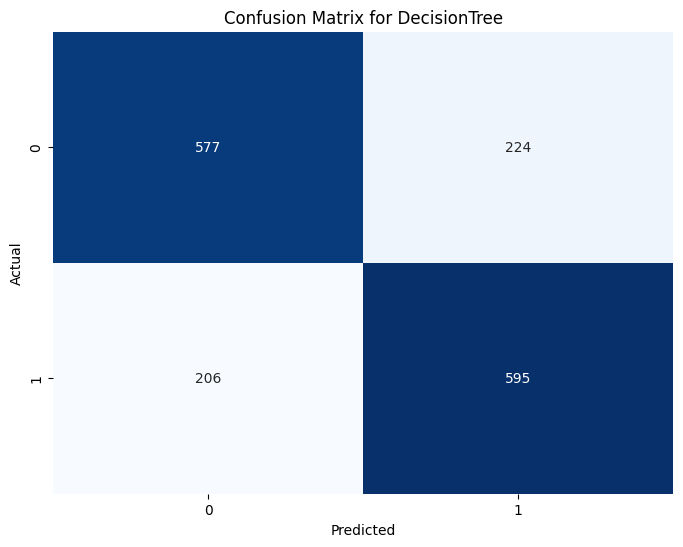

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


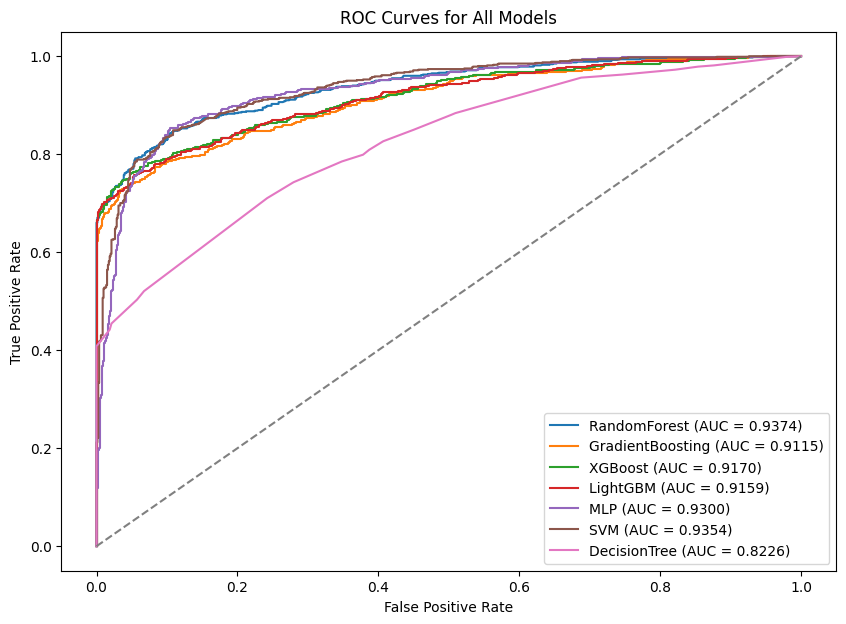

<ipython-input-24-dac87c781c7f>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


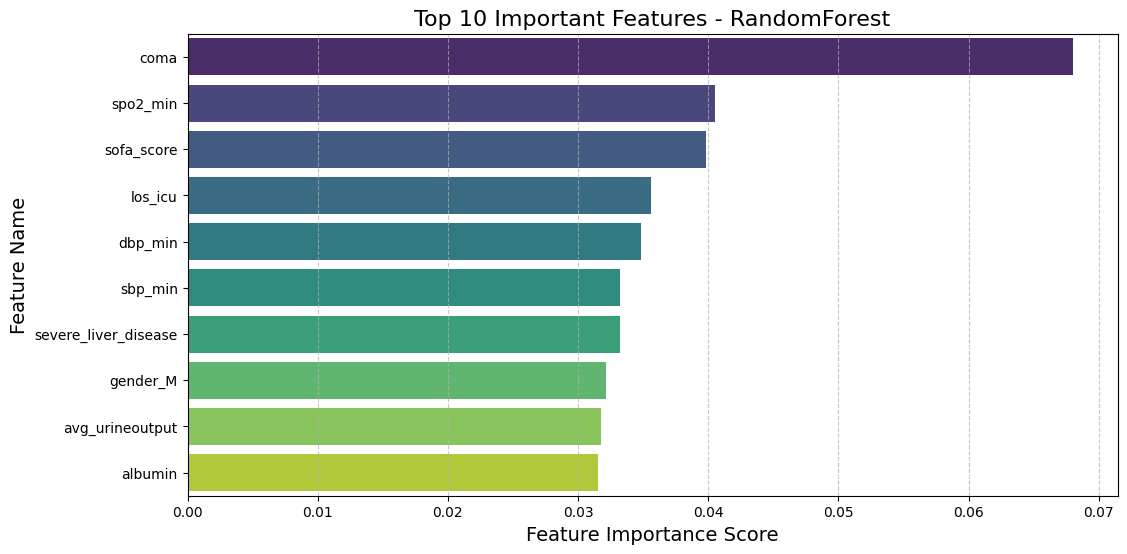

In [ ]:
# Initialize a dictionary to store the best models
best_models = {}

with open("model_performance_report2.txt", "w") as f:
    results = {}
    for name, model in {
        "RandomForest": RandomForestClassifier(random_state=42),
        "GradientBoosting": GradientBoostingClassifier(random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "LightGBM": LGBMClassifier(random_state=42),
        "MLP": MLPClassifier(random_state=42),
        "SVM": SVC(probability=True, random_state=42),
        "DecisionTree": DecisionTreeClassifier(random_state=42)
    }.items():

        f.write(f"Tuning {name} with GridSearchCV...\n")
        print(f"Tuning {name} with GridSearchCV...")
        grid_search = GridSearchCV(model, param_grid[name], cv=StratifiedKFold(n_splits=5), scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_

        # Store the best model in the dictionary
        best_models[name] = best_model

        # Rest of your existing code...
        y_pred = best_model.predict(X_test_scaled)
        y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        print(f"{name} Performance:")
        print(classification_report(y_test, y_pred))
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"ROC-AUC Score: {auc_score:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("Confusion Matrix:")

        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        f.write(f"{name} Performance:\n")
        f.write(f"Best Parameters: {grid_search.best_params_}\n")
        f.write(classification_report(y_test, y_pred) + "\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
        f.write(f"ROC-AUC Score: {auc_score:.4f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1 Score: {f1:.4f}\n")
        f.write("Confusion Matrix:\n")
        f.write(f"{conf_matrix}\n\n")

# Now you can use the best_models dictionary for your ROC curves and feature importance
import seaborn as sns
plt.figure(figsize=(10, 7))
for name, model in best_models.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend()
plt.show()

# Feature importance for RandomForest
if "RandomForest" in best_models:
    rf_model = best_models["RandomForest"]
    importances = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

    top_n = 10
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(top_n)

    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=feature_importance_df['Importance'],
        y=feature_importance_df['Feature'],
        palette='viridis'
    )
    plt.xlabel("Feature Importance Score", fontsize=14)
    plt.ylabel("Feature Name", fontsize=14)
    plt.title(f"Top {top_n} Important Features - RandomForest", fontsize=16)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()

In [ ]:
print(best_models)

{'RandomForest': RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42), 'GradientBoosting': GradientBoostingClassifier(random_state=42), 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...), 'LightGBM': LGBMClassifier(random_state=42), 'MLP': MLPClassifier(hidden_

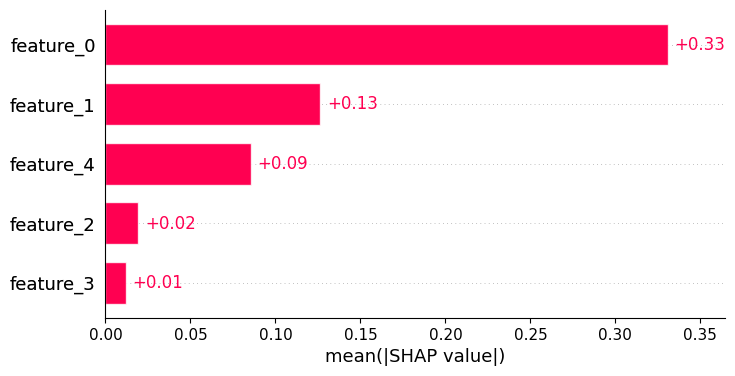

In [ ]:
import shap

# Assuming rf_model is your trained RandomForest model and X_test is a DataFrame with feature names
rf_model = best_models["RandomForest"]

# Create the explainer - make sure to pass the feature names from X_test
explainer = shap.Explainer(rf_model.predict, X_test, feature_names=X_test.columns)

# Calculate SHAP values
shap_values = explainer(X_test)

# Plot the bar plot with feature names
shap.plots.bar(shap_values, show=True)

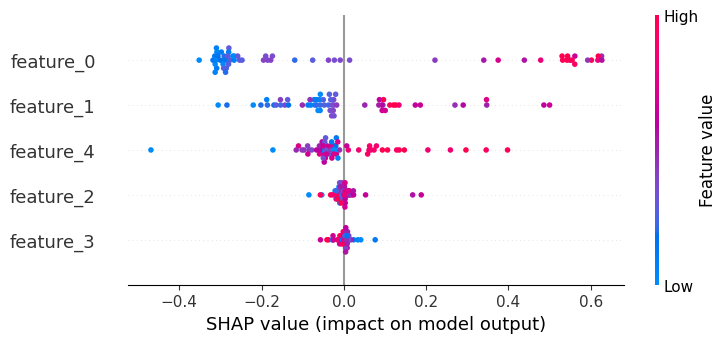

In [ ]:
shap.plots.beeswarm(shap_values)

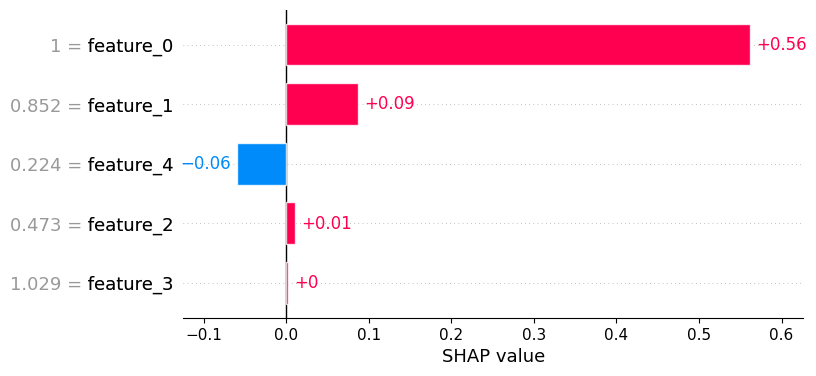

In [ ]:
shap.plots.bar(shap_values[1])

Setting up Stacking Classifier...
Training Stacking Classifier...

Stacking Classifier Evaluation Metrics:
----------------------------------------
Train Accuracy: 0.9998 | AUC: 1.0000 | Precision: 1.0000 | Recall: 0.9997 | F1: 0.9998
Test Accuracy: 0.8895 | AUC: 0.9522 | Precision: 0.9041 | Recall: 0.8714 | F1: 0.8875

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.88      0.91      0.89       801
           1       0.90      0.87      0.89       801

    accuracy                           0.89      1602
   macro avg       0.89      0.89      0.89      1602
weighted avg       0.89      0.89      0.89      1602



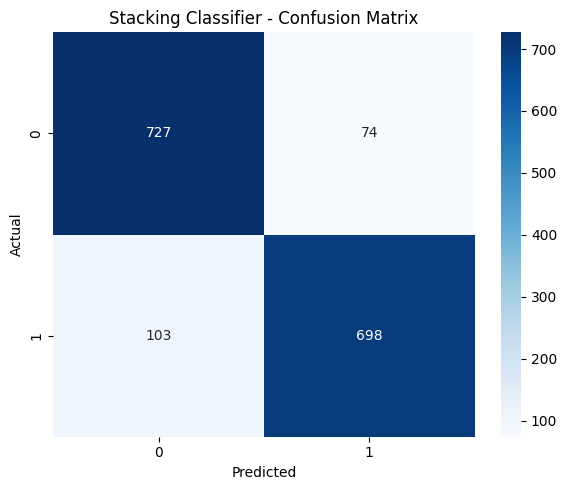

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


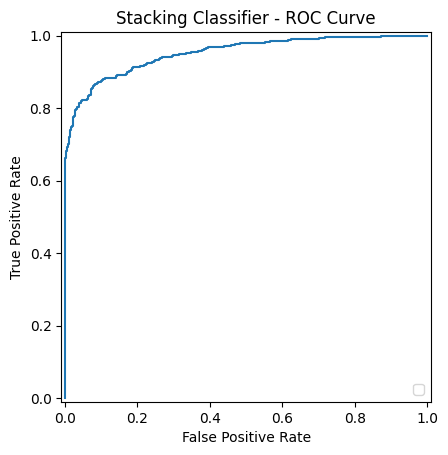


Generating SHAP explanations for base learners...
SHAP Summary for rf:


<ipython-input-16-b5377cb08321>:131: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_scaled[:10], feature_names=X.columns, show=False)


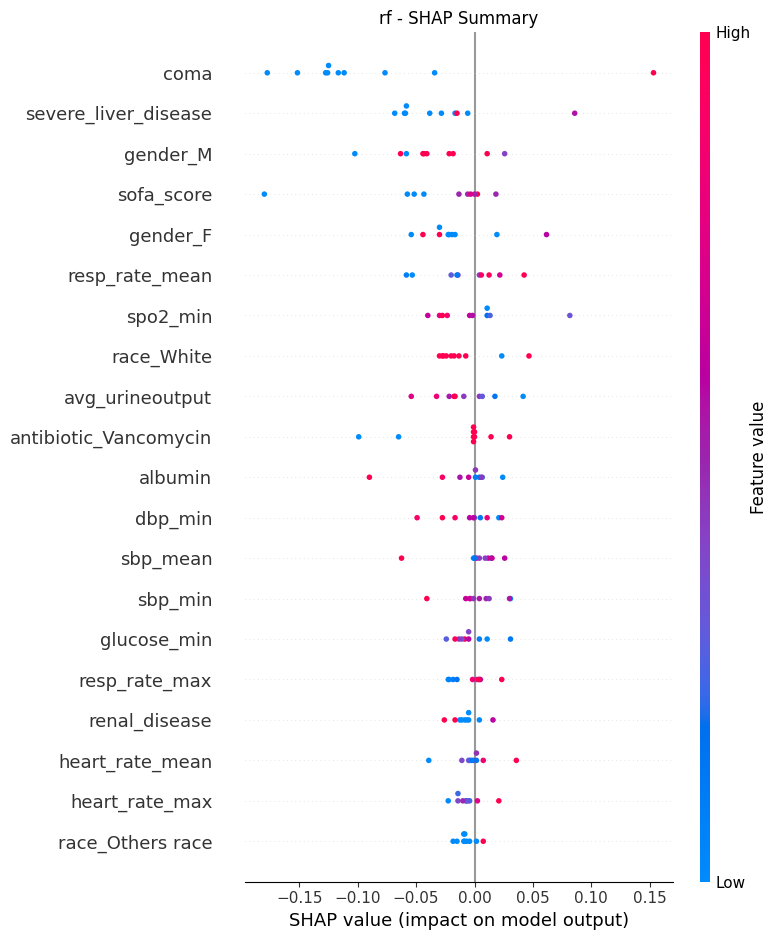

PermutationExplainer explainer: 11it [01:40, 10.06s/it]
<ipython-input-16-b5377cb08321>:131: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_scaled[:10], feature_names=X.columns, show=False)


SHAP Summary for svm:


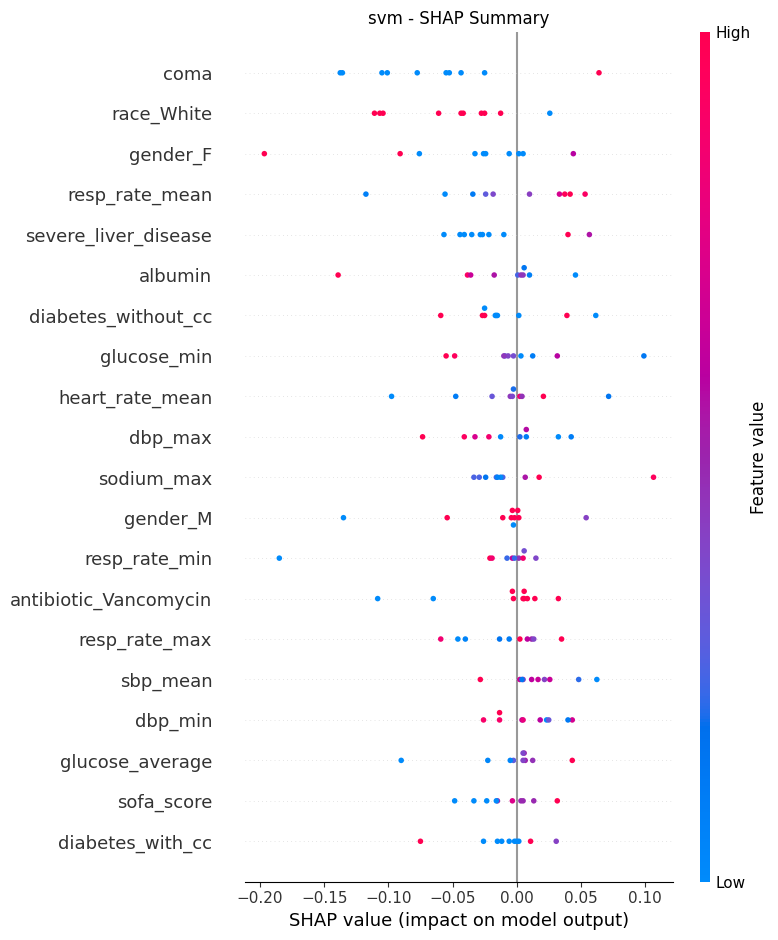

['Stacking_best_model_new.pkl']

In [ ]:
import joblib
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC # Example base model
from xgboost import XGBClassifier # Example base model
from sklearn.ensemble import RandomForestClassifier # Example base model

import pandas as pd
import numpy as np
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, StratifiedKFold, HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import shap
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_halving_search_cv
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, RocCurveDisplay
df = pd.read_csv("data.csv")

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

target = 'hospital_expire_flag'
features = [
    'max_age', 'los_icu', 'sofa_score', 'avg_urineoutput', 'glucose_min', 'glucose_max', 'glucose_average',
    'sodium_max', 'sodium_min', 'sodium_average', 'diabetes_without_cc', 'diabetes_with_cc', 'severe_liver_disease',
    'aids', 'renal_disease', 'heart_rate_min', 'heart_rate_max', 'heart_rate_mean', 'sbp_min', 'sbp_max', 'sbp_mean',
    'dbp_min', 'dbp_max', 'dbp_mean', 'resp_rate_min', 'resp_rate_max', 'resp_rate_mean', 'spo2_min', 'spo2_max',
    'spo2_mean', 'coma', 'albumin', 'race_Black or African American', 'race_Hispanic or Latin', 'race_Others race',
    'race_White', 'antibiotic_Vancomycin', 'gender_F', 'gender_M'
]

X = df[features]
y = df[target]

imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print("Setting up Stacking Classifier...")
# Define base models (use the non-tuned versions or best versions found previously)
# Ensure base models are diverse
# Base models with adjusted complexity to avoid overfitting
estimators = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)),  # Reduced complexity
    ('svm', SVC(C=10, probability=True, random_state=42))  # Reduced complexity
]

# Define the meta-learner
meta_learner = LogisticRegression(solver='liblinear', random_state=42)

# Create the stacking classifier with cross-validation on the base models
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_learner,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # Cross-validation for base model training
    n_jobs=-1
)
# --- Function to evaluate and print metrics ---
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    print(f"\n{name} Evaluation Metrics:\n" + "-"*40)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    for label, y_true, y_pred, y_proba in [
        ("Train", y_train, y_train_pred, y_train_proba),
        ("Test", y_test, y_test_pred, y_test_proba)
    ]:
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_proba)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        print(f"{label} Accuracy: {acc:.4f} | AUC: {auc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))

    # Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.title(f'{name} - ROC Curve')
    plt.show()


# --- Model Training ---
print("Training Stacking Classifier...")
stacking_clf.fit(X_train_scaled, y_train)

# --- Model Evaluation ---
evaluate_model("Stacking Classifier", stacking_clf, X_train_scaled, y_train, X_test_scaled, y_test)

# --- SHAP Explainability (For individual base models) ---
print("\nGenerating SHAP explanations for base learners...")
for name, model in stacking_clf.named_estimators_.items():
    try:
        explainer = shap.Explainer(model.predict, X_train_scaled)
        shap_values = explainer(X_test_scaled[:10])  # Sample 100 for speed
        print(f"SHAP Summary for {name}:")
        shap.summary_plot(shap_values, X_test_scaled[:10], feature_names=X.columns, show=False)
        plt.title(f"{name} - SHAP Summary")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"SHAP not supported for {name}: {e}")

# --- Save Model ---
joblib.dump(stacking_clf, "Stacking_best_model_new.pkl")